In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [284]:
def read_negative_sample_patient_id():
    path = '/Users/wenyuanchen/Desktop/IBM/IBM_Tumor_Project/Data/autoPETmeta.csv'
    raw_df = pd.read_csv(path)
    raw_df.fillna('unknown', inplace=True)
    raw_df[['patient_id','study_id']] = raw_df['study_location'].str.rsplit('/', n=2, expand=True)[[0,1]]
    raw_df['patient_id'] = raw_df['patient_id'].str.split('/').str[-1]
    negative_id_lst = raw_df[raw_df['diagnosis'] =='NEGATIVE']['patient_id']
    return negative_id_lst


In [245]:
negative_id_lst = read_negative_sample_patient_id()

In [246]:
negative_id_lst

3       PETCT_0143bab87a
7       PETCT_0225325b91
9       PETCT_0410759456
10      PETCT_0410759456
12      PETCT_048981112f
              ...       
1007    PETCT_fde79b6aa9
1008    PETCT_fde79b6aa9
1011    PETCT_fe705ea1cc
1012    PETCT_ff1451316e
1013    PETCT_ff39795341
Name: patient_id, Length: 513, dtype: object

In [285]:
path = '../all_patients_results_with_26.csv'
raw_df = pd.read_csv(path)
raw_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.0862,5.2787,2.0571,16.1041
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,59,0.7340,0.9021,4.7366,2.0748,12.3759
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,280,3.4835,1.5159,4.9858,2.0629,15.4478
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,41,0.5101,0.7990,3.2053,2.0643,5.9694
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.1653,7.3036,2.0607,19.6536
...,...,...,...,...,...,...,...,...,...
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,12,0.1493,0.5305,2.5957,2.1719,3.3204
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,35,0.4354,0.7579,3.1296,2.0828,5.3259
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,9,0.1120,0.4820,2.8678,2.1181,3.6940
9130,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,89,41,0.5101,0.7990,3.5326,2.0655,7.3376


In [290]:
remove_negative_sample_df = raw_df[raw_df['Tumor idx'] != 0]
filtered_non_clinical_important_tumor_df = remove_negative_sample_df[remove_negative_sample_df['In Diameter(cm)']> 1]
filtered_non_clinical_important_tumor_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.0862,5.2787,2.0571,16.1041
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,280,3.4835,1.5159,4.9858,2.0629,15.4478
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.1653,7.3036,2.0607,19.6536
5,PETCT_01140d52d8,08-13-2005-NA-PET-CT Ganzkoerper primaer mit ...,1,130,1.6173,1.1738,8.0991,3.1396,27.1358
6,PETCT_01140d52d8,08-13-2005-NA-PET-CT Ganzkoerper primaer mit ...,2,13133,163.3879,5.4669,11.5883,3.0441,32.9130
...,...,...,...,...,...,...,...,...,...
9118,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,77,377,4.6903,1.6739,3.5857,2.0607,7.2643
9120,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,79,1653,20.5650,2.7397,4.3574,2.0600,15.5222
9121,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,80,250,3.1103,1.4597,3.6185,2.0585,8.0881
9122,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,81,173,2.1523,1.2911,3.7299,2.0671,11.1045


In [295]:
filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'].max()

2144.6827

In [161]:
# filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'] == 'PETCT_30001118d0']

In [249]:
filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'].argmax()

1023

In [250]:
filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'].describe()

count    4424.000000
mean       24.788265
std        97.003037
min         1.007700
25%         1.791500
50%         3.483500
75%        10.428700
max      2144.471200
Name: Physical Vol(cm^3), dtype: float64

/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_31992/3106951259.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_non_clinical_important_tumor_df['Volume Level'] = pd.cut(filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'], bins=bins, labels=labels, right=False)


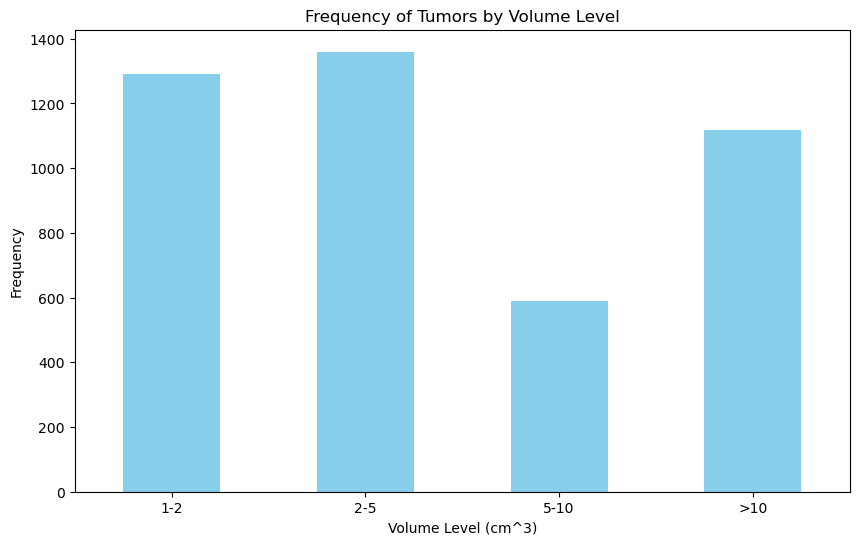

In [287]:
# Define the bins edges
bins = [0, 2, 5, 10, float('inf')]

# Define the labels for the bins
labels = ['1-2', '2-5', '5-10', '>10']

# Use pd.cut to categorize the physical volume into levels
filtered_non_clinical_important_tumor_df['Volume Level'] = pd.cut(filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'], bins=bins, labels=labels, right=False)
# Count the frequency of each volume level
volume_level_counts = filtered_non_clinical_important_tumor_df['Volume Level'].value_counts().reindex(labels)

# Plot a bar chart
plt.figure(figsize=(10, 6))
volume_level_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Tumors by Volume Level')
plt.xlabel('Volume Level (cm^3)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the labels on the x-axis vertical
plt.show()

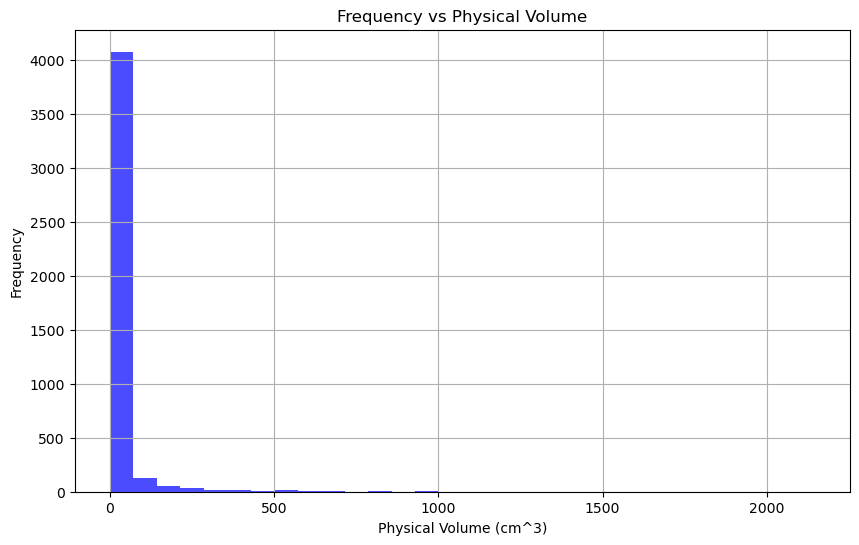

In [288]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'], bins=30, alpha=0.7, color='blue')
plt.title('Frequency vs Physical Volume')
plt.xlabel('Physical Volume (cm^3)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

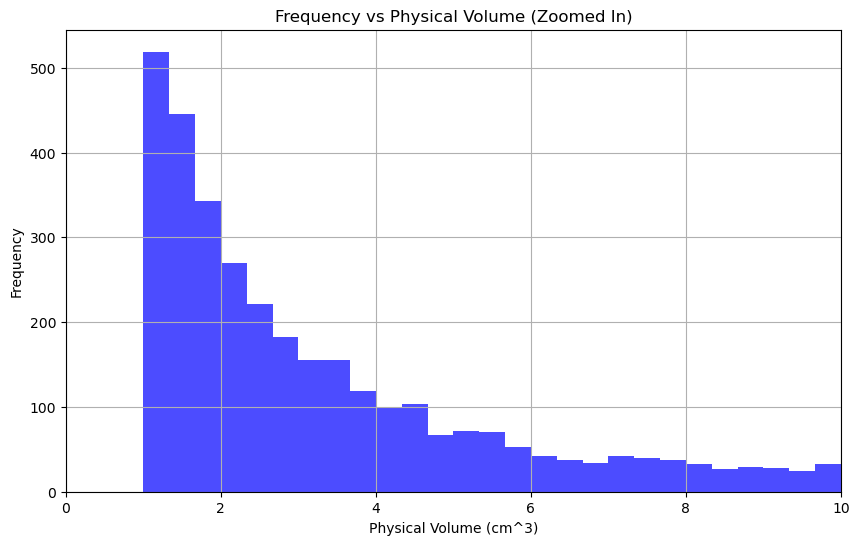

In [253]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_non_clinical_important_tumor_df['Physical Vol(cm^3)'], bins=30, alpha=0.7, color='blue', range=[0, 10])
plt.title('Frequency vs Physical Volume (Zoomed In)')
plt.xlabel('Physical Volume (cm^3)')
plt.ylabel('Frequency')
plt.xlim(left=0, right=10)  # Set X_max to the maximum value of the x-axis you want to display
plt.grid(True)
plt.show()

In [289]:
raw_df.groupby(['Patient ID', 'Study ID']).size()
num_unique_patients = raw_df.groupby(['Patient ID']).size()
assert num_unique_patients.shape[0] == 900

AssertionError: 

In [291]:
num_unique_studies = raw_df.groupby(['Patient ID', 'Study ID']).size()
assert num_unique_studies.shape[0] == 1014

AssertionError: 

In [292]:
tumor_per_study = filtered_non_clinical_important_tumor_df.groupby(['Patient ID', 'Study ID']).size().value_counts()

In [264]:
tumor_per_study

1      94
2      60
3      55
4      47
6      37
5      23
7      23
8      22
9      19
10     14
12      9
23      6
11      6
21      5
25      5
13      5
17      4
19      3
22      3
27      3
36      3
34      3
54      2
20      2
35      2
15      2
79      2
14      2
26      2
30      2
18      2
50      1
86      1
74      1
28      1
43      1
48      1
38      1
331     1
51      1
63      1
60      1
49      1
41      1
55      1
57      1
24      1
32      1
31      1
40      1
Name: count, dtype: int64

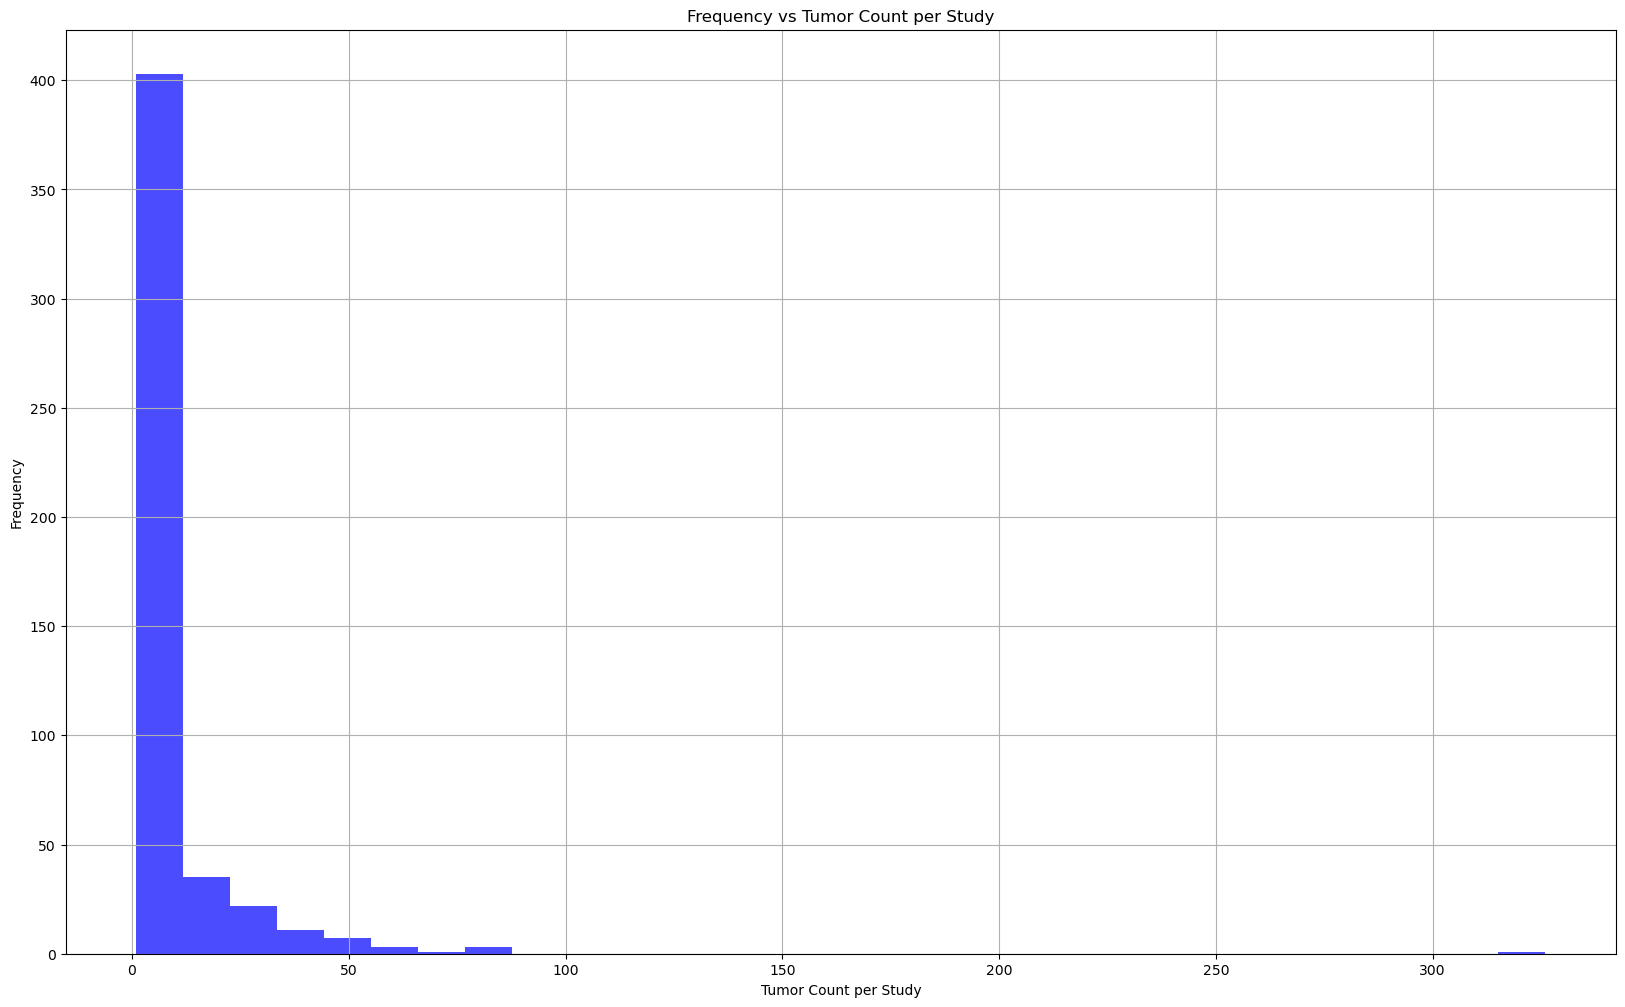

In [294]:
plt.figure(figsize=(20, 12))
plt.hist(filtered_non_clinical_important_tumor_df.groupby(['Patient ID', 'Study ID']).size().values, bins=30, alpha=0.7, color='blue')
plt.title('Frequency vs Tumor Count per Study')
plt.xlabel('Tumor Count per Study')
plt.ylabel('Frequency')
plt.grid(True)

/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_31992/3658428593.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_non_clinical_important_tumor_df['SUV Level'] = pd.cut(filtered_non_clinical_important_tumor_df['SUV Max'], bins=bins, labels=labels, right=False)


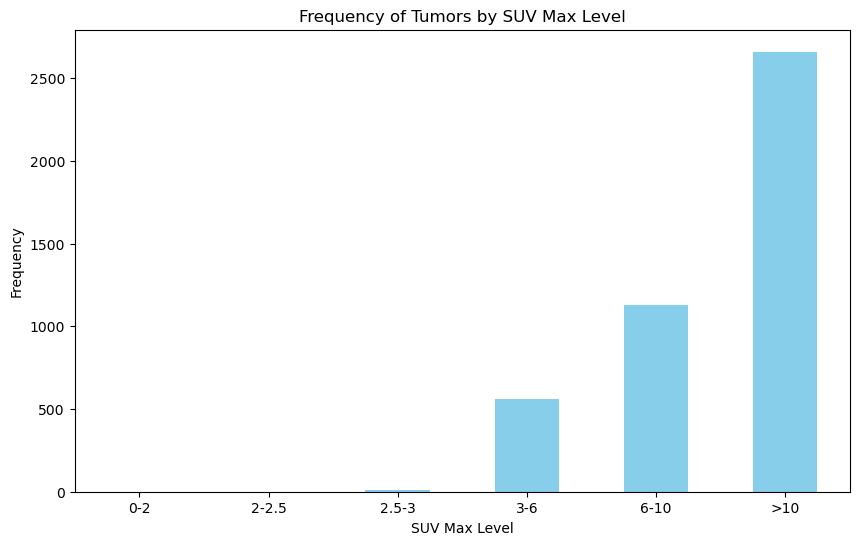

In [296]:
# Define the bins edges
# 0-2, 2-2.5, 2.5-3, 3-6, 6-10, 10+
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]

# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']

# Use pd.cut to categorize the physical volume into levels
filtered_non_clinical_important_tumor_df['SUV Level'] = pd.cut(filtered_non_clinical_important_tumor_df['SUV Max'], bins=bins, labels=labels, right=False)
# Count the frequency of each volume level
SUV_level_counts = filtered_non_clinical_important_tumor_df['SUV Level'].value_counts().reindex(labels)

# Plot a bar chart
plt.figure(figsize=(10, 6))
SUV_level_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Tumors by SUV Max Level')
plt.xlabel('SUV Max Level')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the labels on the x-axis vertical
plt.show()

In [283]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'] == 'PETCT_1285b86bea']

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Volume Level
433,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,5,361,4.4912,1.6499,7.5732,2.6310,39.0494,2-5
435,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,7,2298,28.5895,3.0578,10.0372,2.6282,57.5085,>10
436,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,8,150,1.8662,1.2312,10.7578,3.4023,35.1634,1-2
438,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,10,102,1.2690,1.0826,7.6690,2.6542,36.9239,1-2
441,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,13,527,6.5564,1.8716,11.3898,3.2828,56.0073,5-10
...,...,...,...,...,...,...,...,...,...,...
1452,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1024,174,2.1647,1.2936,8.3292,2.6173,39.5732,2-5
1453,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1025,187,2.3265,1.3251,7.7361,3.2775,36.0632,2-5
1454,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1026,612,7.6139,1.9673,9.5217,2.6248,53.8450,5-10
1455,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1027,754,9.3805,2.1090,9.4717,3.2761,25.9308,5-10
